# Challenging Limitations: Using Deep Learning, Time Series Analysis, and Statistical Methods for Noise Reduction to Develop an Innovative Approach to Exoplanet Candidate Detection

## I. A Comparative Visualization of the Star Fields Visible to Earth-Based and Space-Based Telescopes

In [6]:
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import math
import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

class StarDF(object):
    def __init__(self, path, parse_placeholders, parse_prelim_nans):
        self.path = path
        self.parse_placeholders = parse_placeholders
        self.parse_prelim_nans = parse_prelim_nans
        
    def _gen_df(self):
        data = pd.read_csv(self.path)
        return data
       
    def _initialize(self):
        data = self._gen_df()
        if self.parse_placeholders is True:
            data = data.loc[data['dist'] < 100000]
            data = data.reset_index(drop=True)
        if self.parse_prelim_nans is False:
            data = data[1:]
            data = data.reset_index(drop=True)
        return data
    
    def get_full(self):
        data = self._initialize()
        return data
    
    def split(self):
        data = self._initialize()
        ra = data['ra']
        dec = data['dec']
        dist = data['dist']
        return ra, dec, dist
    
    def split_other(self, data):
        ra = data['ra']
        dec = data['dec']
        dist = data['dist']
        return ra, dec, dist
    
    def convert_to_degrees(self):
        df = self.initialize()
        ra = df['RA_STRING']
        dec = df['DEC_STRING']
        ra = ra.values
        dec = dec.values
        new_ra = np.empty(len(ra))
        new_dec = np.empty(len(dec))
        for i in range(0,len(ra)):
            coord = ra[i] + " " + dec[i]
            c = SkyCoord(coord, unit=(u.hourangle, u.deg))
            temp = c.to_string('decimal')
            temp_b = temp.split(' ')
            new_ra[i] = temp_b[0]
            new_dec[i] = temp_b[1]
        temp = {'ra': new_ra, 'dec': new_dec}
        exo_data = pd.DataFrame(temp, columns = ['ra', 'dec'])
        return exo_data
    
    def intersection(self, df1, df2, cols):
        intersect = pd.merge(df1, df2, on=cols, how='inner')
        intersect = intersect.reset_index(drop=True)
        return intersect
    
    def convert_to_cartesian(self, ra,dec,dist,n =1000):
        x = np.empty(n)
        y = np.empty(n)
        z = np.empty(n)
        for i in range(0,n):
            z[i] = dist[i] * np.sin(dec[i])
            phi = dist[i] * np.cos(dec[i])
            y[i] = phi * np.sin(ra[i])
            x[i] = phi * np.cos(ra[i])
        return x,y,z
    
    def integ_cartesian(self, ra,dec,dist):
        w = dist * np.sin(dec)
        phi = dist * np.cos(dec)
        v = phi * np.sin(ra)
        u = phi * np.cos(ra)
        return u,v,w
    
    def get_stats(self, array):
        return np.mean(array), np.std(array)
    


#parse for dubious parallax data as indicated by HYG database
fullHYG = StarDF('stardata_hyg_v2.csv', parse_placeholders=True, parse_prelim_nans = False)
fullHYG_df = fullHYG.get_full()
hyg_ra, hyg_dec, hyg_dist = fullHYG.split()

exo = StarDF('exo_data.csv', parse_placeholders = False, parse_prelim_nans = True)
exo_df = exo.get_full()

hyg_temp = fullHYG_df.dropna(thresh=7)
exo_temp = exo_df.dropna(thresh=3)
cols = ['HD', 'HIPP']
exo_stars = exo.intersection(hyg_temp, exo_temp, cols)
exo_ra, exo_dec, exo_dist = exo.split_other(exo_stars)

hyg_x,hyg_y,hyg_z = fullHYG.convert_to_cartesian(hyg_ra,hyg_dec,hyg_dist, n = 5000)
exo_x, exo_y, exo_z = exo.convert_to_cartesian(exo_ra, exo_dec, exo_dist, n = len(exo_ra))
    
#initialize kepler vars
kep_x, kep_y, kep_z = np.empty(1), np.empty(1), np.empty(1)
kep_x[0] = 0
kep_y[0] = 0
kep_z[0] = 0
kep_u, kep_v, kep_w = np.empty(1), np.empty(1), np.empty(1)
#following params are center of kepler star field and depth of view of kepler telescope
kep_ra = 290.6667
kep_dec = 44.5
kep_dist = 919.8042
u,v,w = exo.integ_cartesian(kep_ra, kep_dec, kep_dist)
kep_u[0] = u
kep_v[0] = v
kep_w[0] = w


ipv.figure()
selected = (hyg_x[0], hyg_y[0], hyg_z[0])
scatter_a = ipv.scatter(hyg_x,hyg_y,hyg_z,size=0.4, size_selected = 0.6, marker="sphere", selected = selected)
exo_scatter = ipv.scatter(exo_x, exo_y, exo_z, size = 0.4, marker = 'sphere', color= '#00c8ff')
kep_vector = ipv.quiver(kep_x, kep_y, kep_z, kep_u, kep_v, kep_w, size=5)

size = FloatSlider(min=0.1, max=2, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
exo_color = ColorPicker()
kep_color = ColorPicker()
kep_size = FloatSlider(min=0, max = 10, step = 0.1)
jslink((scatter_a, 'size'), (size, 'value'))
jslink((scatter_a, 'color'), (color, 'value'))
jslink((scatter_a, 'color_selected'), (color_selected, 'value'))
jslink((exo_scatter, 'color'), (exo_color, 'value'))
jslink((kep_vector, 'color'), (kep_color, 'value'))
jslink((kep_vector, 'size'), (kep_size, 'value'))
VBox([ipv.gcc(), size, color, color_selected, exo_color, kep_color, kep_size])#size, color_b


VBox(children=(VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white',
      dtype='<U5'), geo='sphere', selected=array([  1.01838186e+02,   6.11029114e-03,   1.94762215e+02]), size=array(0.4), size_selected=array(0.6), x=array([ 101.83818558,   38.20222153,  176.63109425, ...,   30.98292621,
        213.56678181,  -87.4840481 ]), y=array([  6.11029114e-03,   1.08112290e-02,   5.91714188e-02, ...,
         7.06614483e+01,   4.87806045e+02,  -1.99953800e+02]), z=array([ 194.76221459,  -28.99836596,  405.69464506, ...,  -85.91346874,
        -74.06241054,  -25.85257517])), Scatter(color=array('#00c8ff',
      dtype='<U7'), color_selected=array('white',
      dtype='<U5'), geo='sphere', size=array(0.4), size_selected=array(2.6), x=array([  9.49688301e+00,  -4.32626151e+00,   3.41764154e+00,
        -4.37437446e+00,   1.24368339e+01,   6.76092745e+01,
         6.76092745e+01,   4.79079771e+01,  -1.20703604e+02,
         9.37578736e+01,  -2.75609480e+01,   3.80406004e+01,
        -8.04303534e+00,  -6.46760459e+00,   3.17924282e+01,
         4.46164660e+00,  -1.53809036e+01,  -1.62211746e+00,
         8.88688059e-01,   2.14617733e+01,   2.14617733e+01,
         4.89981197e+01,   4.89981197e+01,  -3.12511540e+01,
        -2.61565527e+01,   1.70619628e+01,  -4.24056315e+00,
        -1.67047059e+01,  -8.67174165e+00,  -1.14483025e+01,
        -1.14483025e+01,  -1.31449793e+01,   4.13868581e+00,
         8.72807344e-01,   8.72807344e-01,   8.72807344e-01,
        -8.41954331e+00,  -6.40464856e+00,  -4.35932197e-01,
        -4.35932197e-01,   4.84241185e-01,   4.84241185e-01,
         4.84241185e-01,   6.53252772e-01,   1.61398346e+00,
         1.61398346e+00,   1.61398346e+00,   1.61398346e+00,
         1.61398346e+00,   1.61398346e+00,   2.25494180e+00,
        -1.90863907e+00,  -1.24822350e+01,  -1.24822350e+01,
        -2.33209195e+00,   8.37304792e+00,   8.37304792e+00,
         5.83120715e+01,  -1.62561829e+01,  -1.62561829e+01,
         1.04576086e+00,  -1.94272301e+02,  -5.18581941e+00,
        -2.81682523e+01,   4.42538346e+01,   4.42538346e+01,
         6.59414061e+01,  -8.78809307e+01,  -3.41852889e+01,
         3.02871741e+01,  -3.12158645e+01,   2.22991830e+01,
         1.71239204e+01,   7.79873941e+01,  -2.49794120e+01,
        -1.34112602e+01,   9.84607116e+00,   6.25279333e+01,
         4.99907980e+01,   3.34478568e+01,   3.34478568e+01,
         3.34478568e+01,  -8.24248356e+00,  -3.63033056e+00,
        -3.63033056e+00,  -3.63033056e+00,   2.91693778e+01,
         3.06286063e+01,   2.95140442e+00,   7.95416808e+01,
         2.59242325e+01,  -2.57963990e+01,   3.79822910e+01,
        -7.00808663e+00,   2.73570634e+01,  -4.67200925e+01,
         2.15906007e+01,   7.93711604e+00,   7.93711604e+00,
         7.93711604e+00,   7.15472227e+00,   1.50950851e+01,
        -1.50570587e+01,   4.88910326e+00,  -9.92011003e+00,
         5.81200556e+00,   1.97716938e+00,  -7.26817176e-02,
         2.85613734e-02,   2.11400412e+00,   1.07062633e+01,
         1.87201356e+00,   9.75243851e+00,   7.60818809e+00,
         5.44004489e+00,  -3.61119205e+00,   4.52114748e+01,
        -4.01135001e+00,  -3.50187318e+01,  -3.50187318e+01,
        -1.97616365e+01,   1.22666038e+01,  -9.91142011e+00,
        -2.30482166e+01,  -3.84813303e+00,  -8.08841846e+00,
        -8.08841846e+00,  -8.08841846e+00,   5.06086062e+00,
         3.50059641e+01,   3.50059641e+01,   1.34548526e+01,
         1.34548526e+01,   1.19049902e+01,  -3.66537173e+01,
        -1.13955310e+01,  -1.13955310e+01,  -1.13955310e+01,
         3.11523017e+01,   9.93978490e+01,   2.92971073e+00,
        -7.77826034e+01,  -1.34586257e+01,   3.22828884e+01,
         3.22828884e+01,   1.44844834e+01,  -2.07380134e+00,
        -2.34486724e+

## II. A Visual Approximation of the Effect of Increased Participation on the Efficacy of the Proposed Methodology

KeyError: 'avconv'

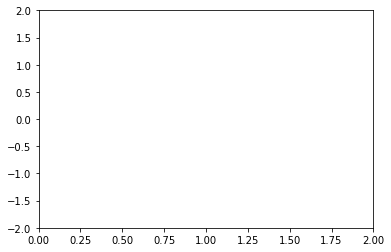

In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import animation, rc
from IPython.display import HTML


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

## III. A Rough Statistical Analysis of Project Potential